# Cloud Detection Filter (Classic Image Processing)

**Obiettivo**: Identificare e evidenziare le nuvole nelle immagini usando tecniche di image processing classico.

**Caratteristiche delle nuvole**:
- Alta luminosità (brightness/value)
- Bassa saturazione (colori tendenti al bianco/grigio)
- Canali RGB con valori simili (bianco = R≈G≈B)

**Approccio**:
1. Filtro HSV: soglie su alta V (Value) e bassa S (Saturation)
2. Filtro RGB: rapporto tra canali (std basso = colori uniformi)
3. Combinazione filtri con operazioni morfologiche
4. Visualizzazione: overlay blu + side-by-side
5. Valutazione su immagini cloudy vs non-cloudy

## 1. Imports

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
import random
from typing import Tuple, List

# Set random seed
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

print("Imports completed successfully")

Imports completed successfully


## 2. Configuration

In [4]:
# Paths
DATA_DIR = Path('../data')
CATEGORIES = ['cloudy', 'desert', 'green_area', 'water']
TARGET_SIZE = (64, 64)

# Filter parameters (to be tuned)
HSV_THRESHOLDS = {
    'min_value': 150,      # Minimum brightness (0-255)
    'max_saturation': 80,  # Maximum saturation (0-255)
}

RGB_THRESHOLDS = {
    'max_std': 25,         # Maximum std across RGB channels
    'min_brightness': 150, # Minimum average brightness
}

# Morphological operations
MORPH_KERNEL_SIZE = 3

# Visualization
CLOUD_COLOR = (0, 0, 255)  # Blue in RGB
OVERLAY_ALPHA = 0.4

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"HSV thresholds: {HSV_THRESHOLDS}")
print(f"RGB thresholds: {RGB_THRESHOLDS}")

Data directory: /Users/aldojacopo/forme-idee/notebooks/../data
HSV thresholds: {'min_value': 150, 'max_saturation': 80}
RGB thresholds: {'max_std': 25, 'min_brightness': 150}


## 3. Utility Functions

In [5]:
def load_and_resize_image(img_path: Path, target_size: Tuple[int, int] = TARGET_SIZE) -> np.ndarray:
    """
    Load an image and resize it to target size.
    
    Args:
        img_path: Path to image file
        target_size: (width, height) tuple
    
    Returns:
        numpy array (H, W, 3) in RGB format
    """
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.LANCZOS)
    return np.array(img_resized)


def load_sample_images(category: str, n_samples: int = 10) -> List[np.ndarray]:
    """
    Load random sample images from a category.
    """
    category_path = DATA_DIR / category
    image_files = list(category_path.glob('*.jpg'))
    sampled_files = random.sample(image_files, min(n_samples, len(image_files)))
    return [load_and_resize_image(f) for f in sampled_files]


print("Utility functions defined")

Utility functions defined


## 4. Cloud Detection Filters

In [6]:
def detect_clouds_hsv(img_rgb: np.ndarray, 
                      min_value: int = HSV_THRESHOLDS['min_value'],
                      max_saturation: int = HSV_THRESHOLDS['max_saturation']) -> np.ndarray:
    """
    Detect clouds using HSV color space.
    Clouds typically have high Value (brightness) and low Saturation.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        min_value: Minimum V threshold (0-255)
        max_saturation: Maximum S threshold (0-255)
    
    Returns:
        Binary mask (H, W) where 255 = cloud, 0 = not cloud
    """
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
    # Extract channels
    h, s, v = cv2.split(img_hsv)
    
    # Apply thresholds: high V AND low S
    mask_v = v >= min_value
    mask_s = s <= max_saturation
    
    # Combine masks
    mask = (mask_v & mask_s).astype(np.uint8) * 255
    
    return mask


def detect_clouds_rgb(img_rgb: np.ndarray,
                      max_std: float = RGB_THRESHOLDS['max_std'],
                      min_brightness: float = RGB_THRESHOLDS['min_brightness']) -> np.ndarray:
    """
    Detect clouds using RGB color space.
    Clouds have similar R, G, B values (low std) and high brightness.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        max_std: Maximum standard deviation across RGB channels
        min_brightness: Minimum average brightness
    
    Returns:
        Binary mask (H, W) where 255 = cloud, 0 = not cloud
    """
    # Calculate per-pixel std across RGB channels
    img_float = img_rgb.astype(np.float32)
    pixel_std = np.std(img_float, axis=2)
    
    # Calculate per-pixel brightness (average of RGB)
    brightness = np.mean(img_float, axis=2)
    
    # Apply thresholds
    mask_std = pixel_std <= max_std
    mask_bright = brightness >= min_brightness
    
    # Combine masks
    mask = (mask_std & mask_bright).astype(np.uint8) * 255
    
    return mask


def detect_clouds_combined(img_rgb: np.ndarray,
                          use_morph: bool = True,
                          kernel_size: int = MORPH_KERNEL_SIZE) -> np.ndarray:
    """
    Combine HSV and RGB filters for robust cloud detection.
    Apply morphological operations to clean up the mask.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        use_morph: Whether to apply morphological operations
        kernel_size: Size of morphological kernel
    
    Returns:
        Binary mask (H, W) where 255 = cloud, 0 = not cloud
    """
    # Get masks from both methods
    mask_hsv = detect_clouds_hsv(img_rgb)
    mask_rgb = detect_clouds_rgb(img_rgb)
    
    # Combine with OR operation (pixel is cloud if detected by either method)
    mask_combined = cv2.bitwise_or(mask_hsv, mask_rgb)
    
    # Apply morphological operations to reduce noise
    if use_morph:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # Opening: erosion followed by dilation (removes small noise)
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel)
        
        # Closing: dilation followed by erosion (fills small holes)
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel)
    
    return mask_combined


print("Cloud detection filters defined")

Cloud detection filters defined


## 5. Visualization Functions

In [7]:
def apply_colored_overlay(img_rgb: np.ndarray, 
                         mask: np.ndarray,
                         color: Tuple[int, int, int] = CLOUD_COLOR,
                         alpha: float = OVERLAY_ALPHA) -> np.ndarray:
    """
    Apply a colored semi-transparent overlay to the image based on the mask.
    
    Args:
        img_rgb: Original RGB image (H, W, 3)
        mask: Binary mask (H, W) where 255 = apply overlay
        color: RGB color tuple for overlay
        alpha: Transparency (0=transparent, 1=opaque)
    
    Returns:
        Image with overlay applied (H, W, 3)
    """
    # Create overlay image
    overlay = np.zeros_like(img_rgb)
    overlay[mask > 0] = color
    
    # Blend original image with overlay
    result = img_rgb.copy()
    mask_bool = mask > 0
    result[mask_bool] = (alpha * overlay[mask_bool] + 
                         (1 - alpha) * img_rgb[mask_bool]).astype(np.uint8)
    
    return result


def visualize_detection(img_rgb: np.ndarray,
                       mask: np.ndarray,
                       title: str = "Cloud Detection") -> None:
    """
    Visualize original image, mask, and overlay side-by-side.
    
    Args:
        img_rgb: Original RGB image
        mask: Binary detection mask
        title: Plot title
    """
    overlay = apply_colored_overlay(img_rgb, mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Detection Mask', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (Blue = Clouds)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def visualize_filter_comparison(img_rgb: np.ndarray) -> None:
    """
    Compare HSV, RGB, and combined filter results.
    """
    mask_hsv = detect_clouds_hsv(img_rgb)
    mask_rgb = detect_clouds_rgb(img_rgb)
    mask_combined = detect_clouds_combined(img_rgb)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Original
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # HSV filter
    axes[0, 1].imshow(mask_hsv, cmap='gray')
    axes[0, 1].set_title('HSV Filter (high V, low S)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # RGB filter
    axes[1, 0].imshow(mask_rgb, cmap='gray')
    axes[1, 0].set_title('RGB Filter (low std, high brightness)', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Combined filter
    axes[1, 1].imshow(mask_combined, cmap='gray')
    axes[1, 1].set_title('Combined + Morphology', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    plt.suptitle('Filter Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("Visualization functions defined")

Visualization functions defined


## 6. Test on Sample Images

### 6.1 Test on Cloudy Images

Loaded 5 cloudy images

Testing on cloudy image, shape: (64, 64, 3)


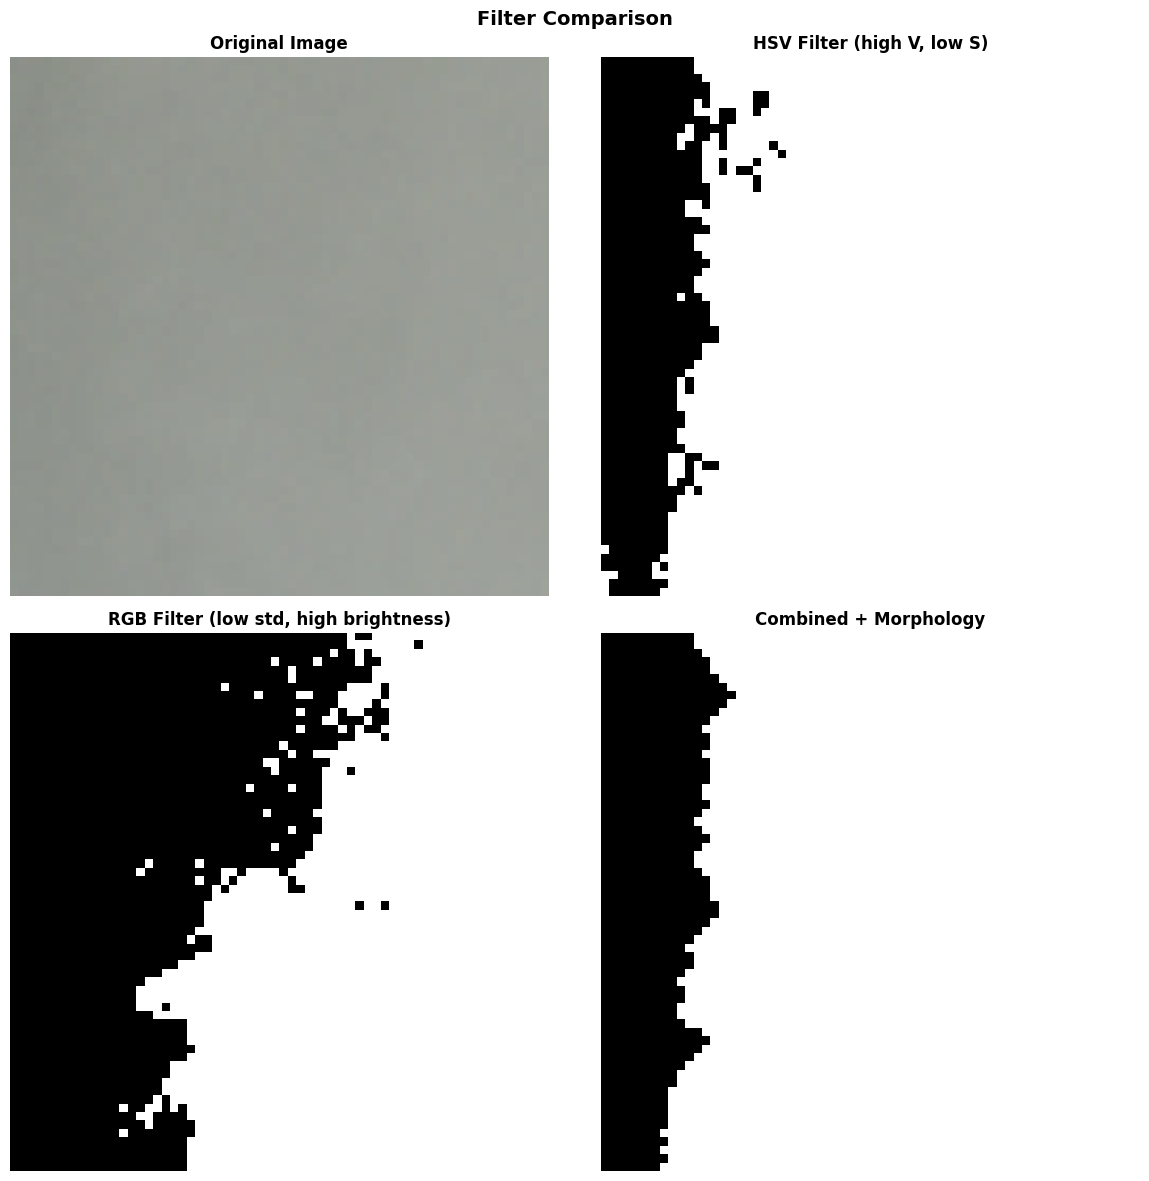

In [8]:
# Load cloudy samples
cloudy_samples = load_sample_images('cloudy', n_samples=5)
print(f"Loaded {len(cloudy_samples)} cloudy images")

# Test filter on first cloudy image
test_img = cloudy_samples[0]
print(f"\nTesting on cloudy image, shape: {test_img.shape}")

# Compare different filters
visualize_filter_comparison(test_img)

Testing cloud detection on multiple cloudy images:


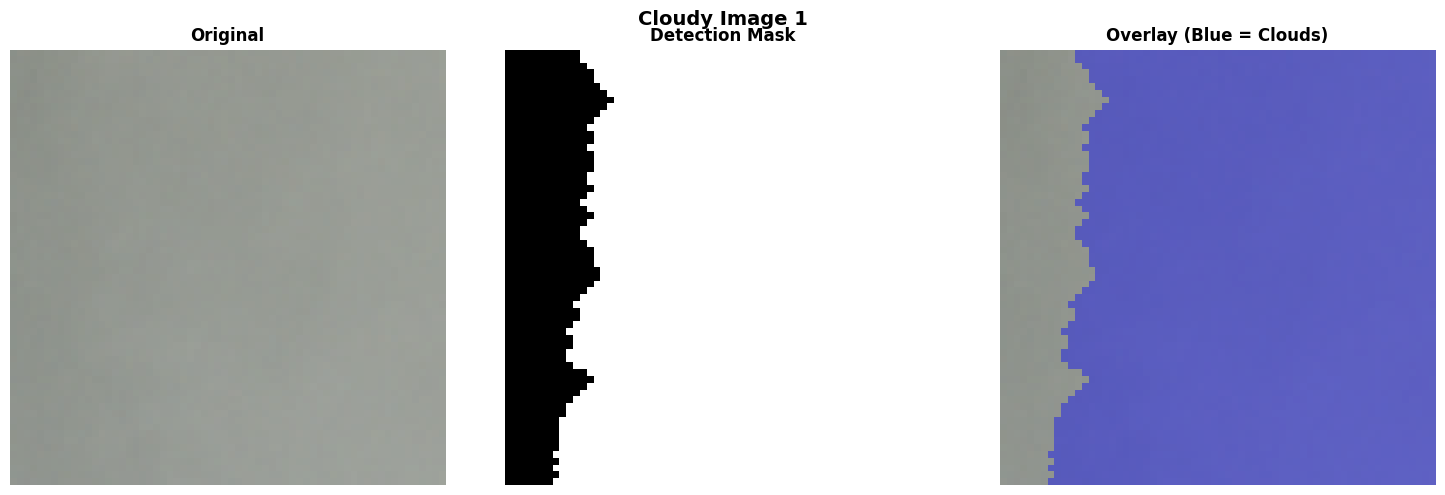

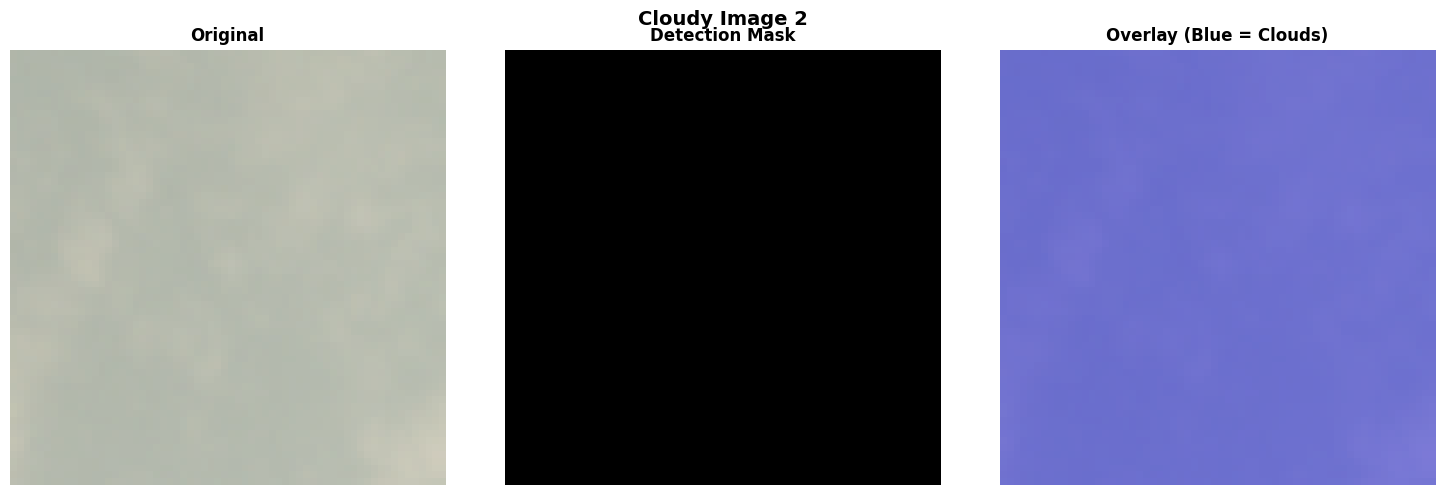

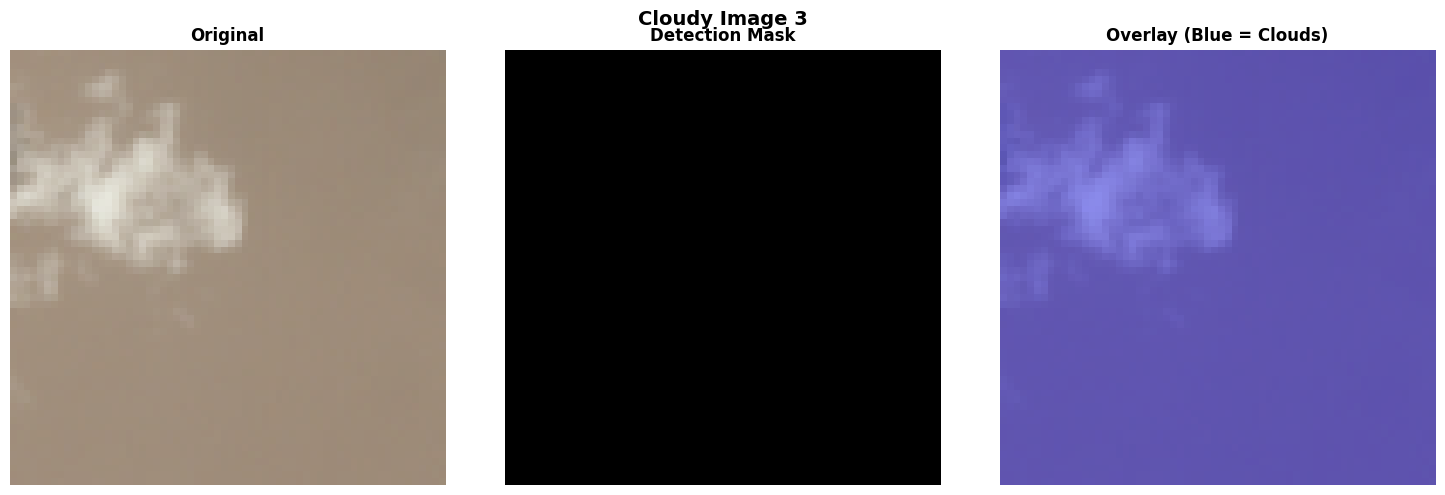

In [9]:
# Test on multiple cloudy images
print("Testing cloud detection on multiple cloudy images:")
for i, img in enumerate(cloudy_samples[:3]):
    mask = detect_clouds_combined(img)
    visualize_detection(img, mask, title=f"Cloudy Image {i+1}")

### 6.2 Test on Non-Cloudy Images (Control)

Testing cloud detection on NON-cloudy images:
(Should detect minimal or no clouds)

--- Desert ---


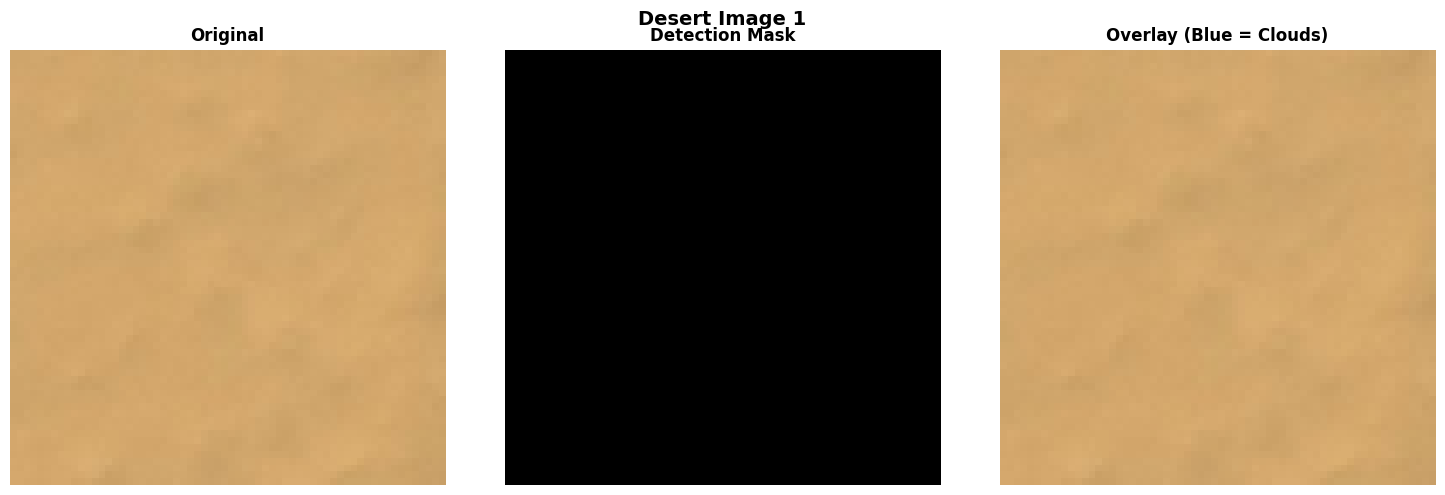

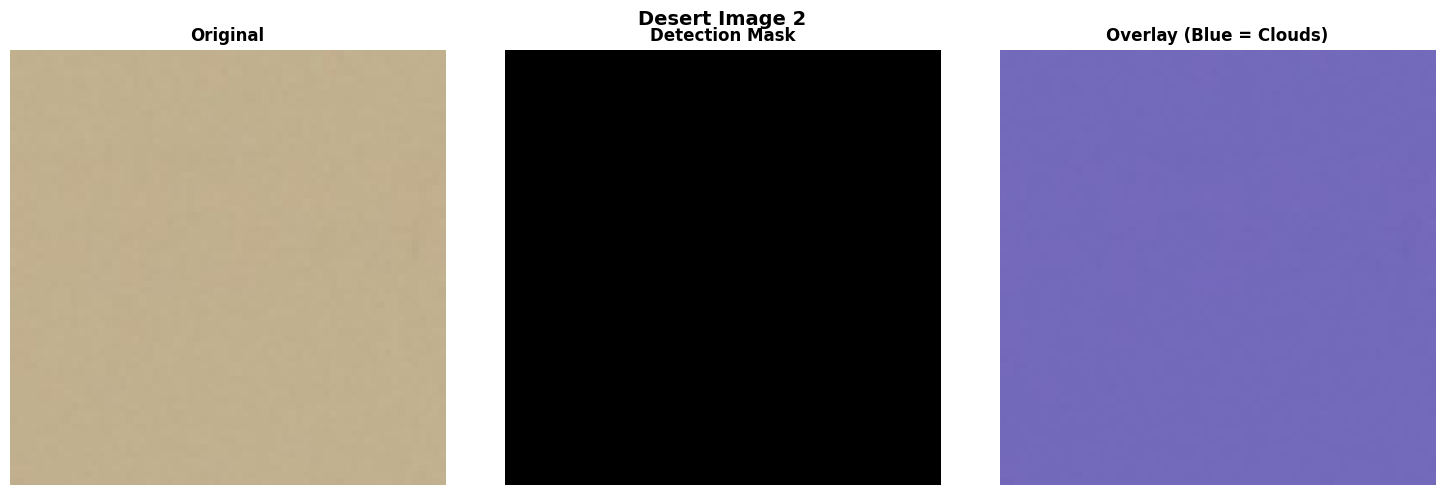

--- Vegetation ---


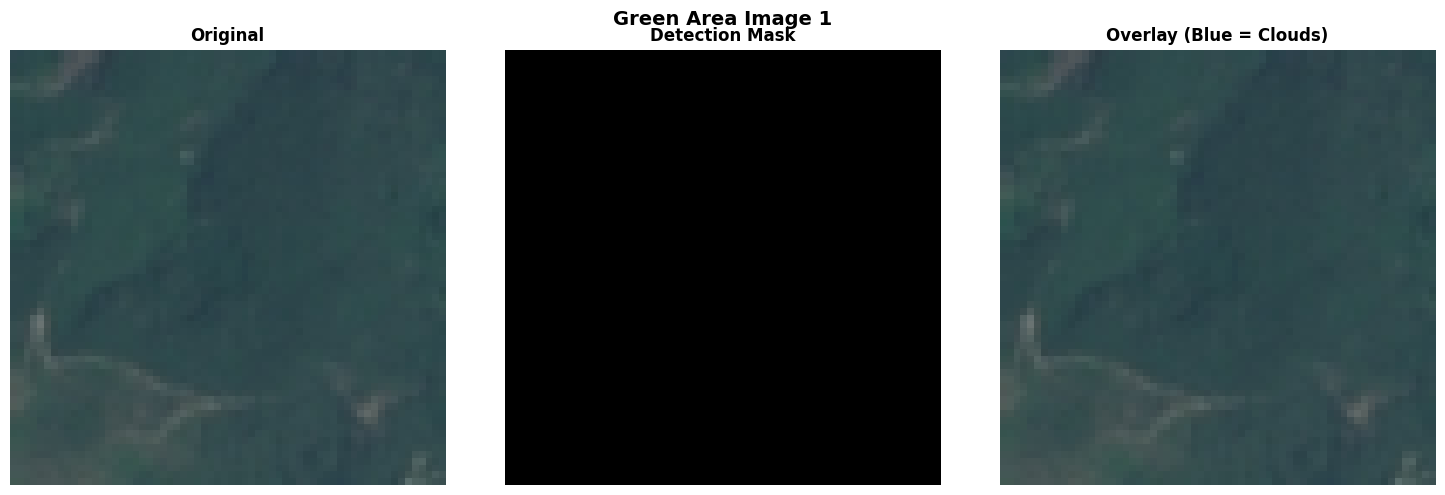

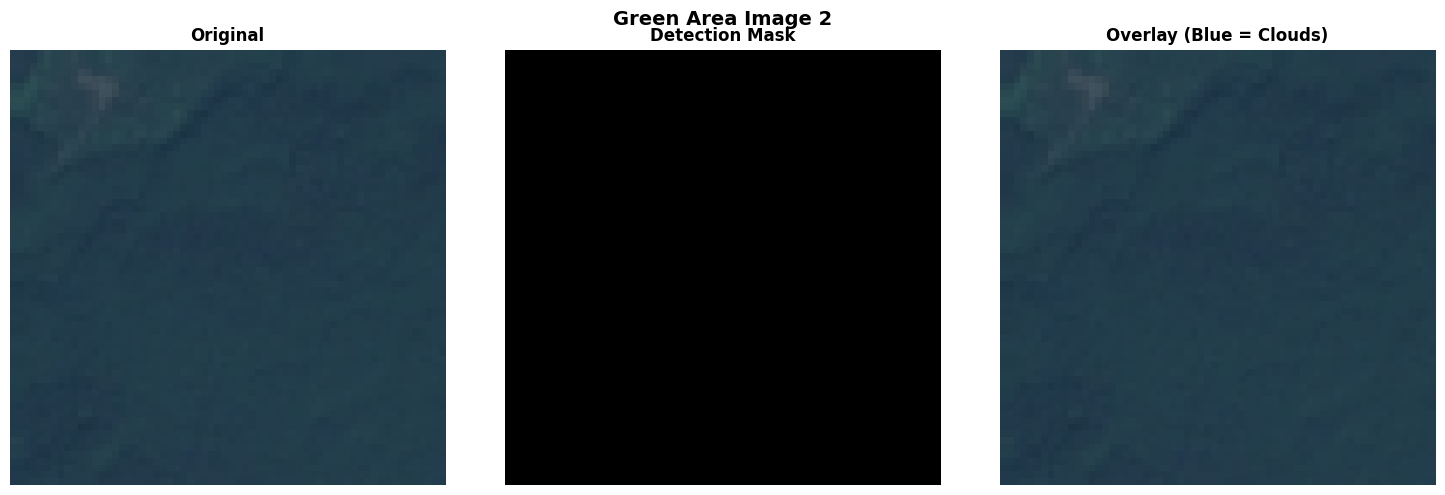

--- Water ---


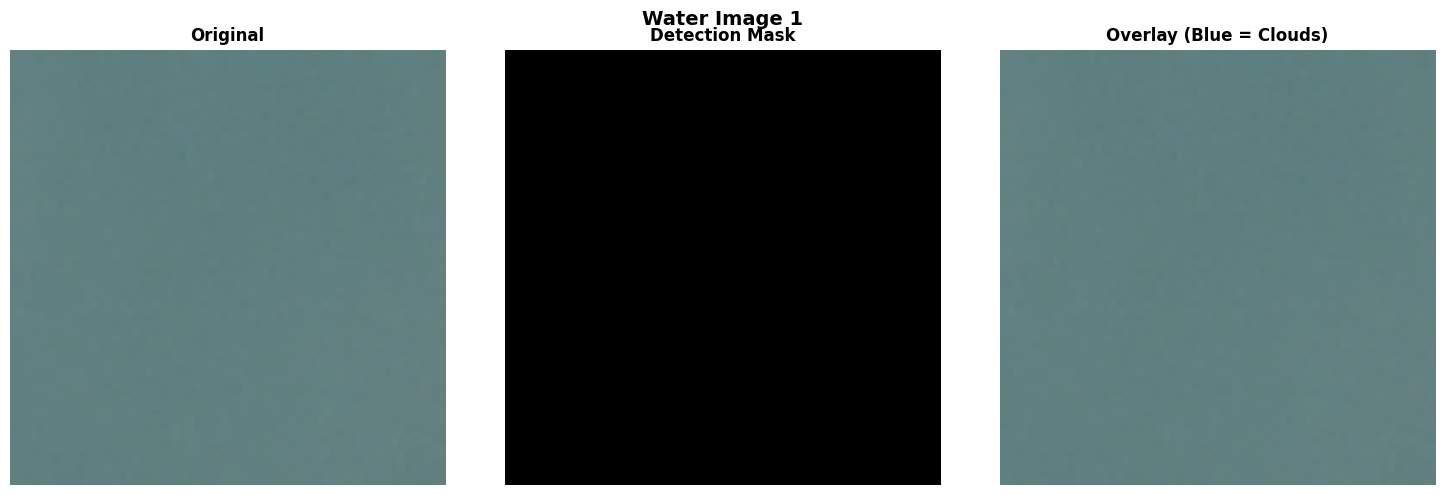

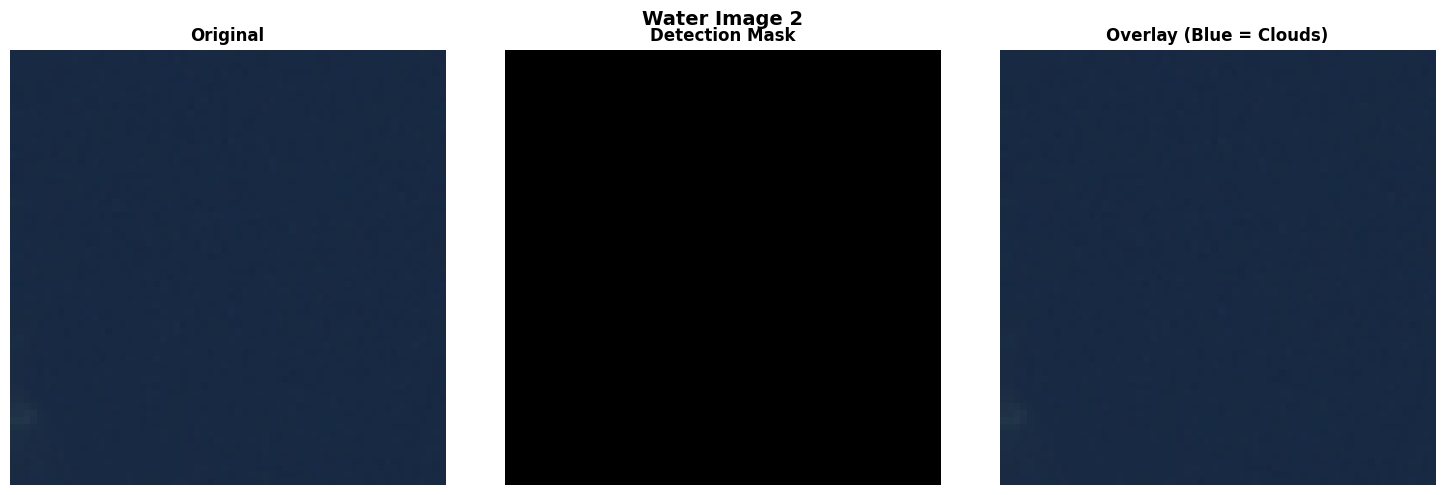

In [10]:
# Load samples from other categories
desert_samples = load_sample_images('desert', n_samples=2)
green_samples = load_sample_images('green_area', n_samples=2)
water_samples = load_sample_images('water', n_samples=2)

print("Testing cloud detection on NON-cloudy images:")
print("(Should detect minimal or no clouds)\n")

# Test desert
print("--- Desert ---")
for i, img in enumerate(desert_samples):
    mask = detect_clouds_combined(img)
    visualize_detection(img, mask, title=f"Desert Image {i+1}")

# Test vegetation
print("--- Vegetation ---")
for i, img in enumerate(green_samples):
    mask = detect_clouds_combined(img)
    visualize_detection(img, mask, title=f"Green Area Image {i+1}")

# Test water
print("--- Water ---")
for i, img in enumerate(water_samples):
    mask = detect_clouds_combined(img)
    visualize_detection(img, mask, title=f"Water Image {i+1}")

## 7. Quantitative Evaluation

In [11]:
def calculate_cloud_coverage(mask: np.ndarray) -> float:
    """
    Calculate percentage of image covered by clouds.
    
    Args:
        mask: Binary mask (H, W)
    
    Returns:
        Percentage (0-100)
    """
    total_pixels = mask.size
    cloud_pixels = np.sum(mask > 0)
    return (cloud_pixels / total_pixels) * 100


def evaluate_filter_on_category(category: str, n_samples: int = 20) -> dict:
    """
    Evaluate cloud filter on a category and compute statistics.
    
    Returns:
        dict with mean, std, min, max cloud coverage percentage
    """
    images = load_sample_images(category, n_samples)
    coverages = []
    
    for img in images:
        mask = detect_clouds_combined(img)
        coverage = calculate_cloud_coverage(mask)
        coverages.append(coverage)
    
    return {
        'mean': np.mean(coverages),
        'std': np.std(coverages),
        'min': np.min(coverages),
        'max': np.max(coverages)
    }


print("Evaluating cloud detection across all categories...\n")

results = {}
for category in CATEGORIES:
    print(f"Processing {category}...")
    results[category] = evaluate_filter_on_category(category, n_samples=20)

print("\n" + "="*70)
print("CLOUD COVERAGE STATISTICS (%)")
print("="*70)
for category in CATEGORIES:
    stats = results[category]
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Mean:   {stats['mean']:.2f}%")
    print(f"  Std:    {stats['std']:.2f}%")
    print(f"  Range:  {stats['min']:.2f}% - {stats['max']:.2f}%")

print("\n" + "="*70)
print("Expected: Cloudy images should have HIGH coverage (>50%)")
print("          Other categories should have LOW coverage (<20%)")
print("="*70)

Evaluating cloud detection across all categories...

Processing cloudy...
Processing desert...
Processing green_area...
Processing water...

CLOUD COVERAGE STATISTICS (%)

Cloudy:
  Mean:   57.07%
  Std:    42.17%
  Range:  0.00% - 100.00%

Desert:
  Mean:   64.03%
  Std:    44.69%
  Range:  0.00% - 100.00%

Green Area:
  Mean:   0.00%
  Std:    0.00%
  Range:  0.00% - 0.00%

Water:
  Mean:   0.00%
  Std:    0.00%
  Range:  0.00% - 0.00%

Expected: Cloudy images should have HIGH coverage (>50%)
          Other categories should have LOW coverage (<20%)


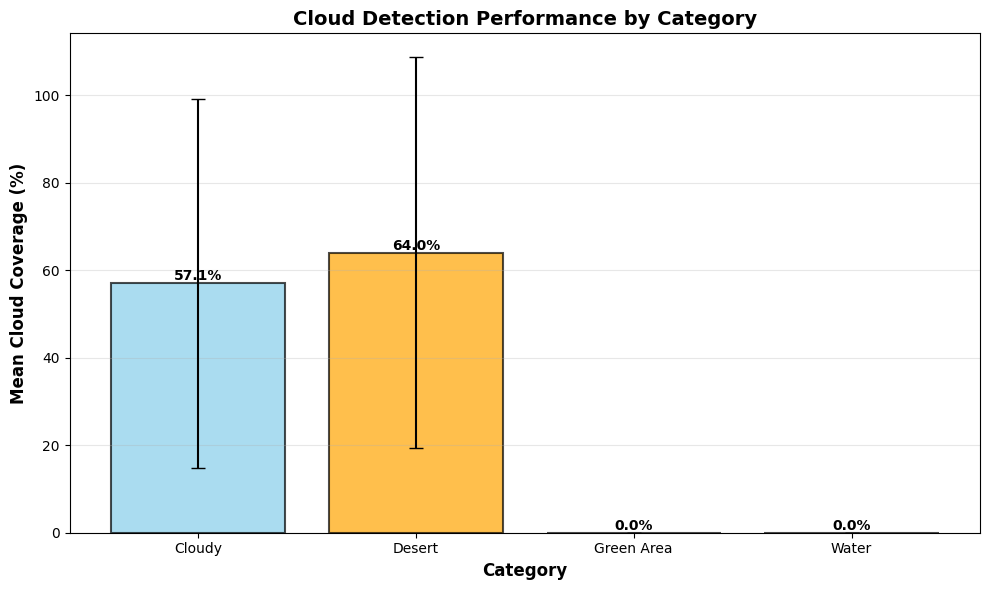

In [12]:
# Visualize results as bar chart
categories_labels = [cat.replace('_', ' ').title() for cat in CATEGORIES]
means = [results[cat]['mean'] for cat in CATEGORIES]
stds = [results[cat]['std'] for cat in CATEGORIES]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(categories_labels))
bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, 
              color=['skyblue', 'orange', 'green', 'cyan'],
              edgecolor='black', linewidth=1.5)

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Cloud Coverage (%)', fontsize=12, fontweight='bold')
ax.set_title('Cloud Detection Performance by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories_labels)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Parameter Tuning (Optional)

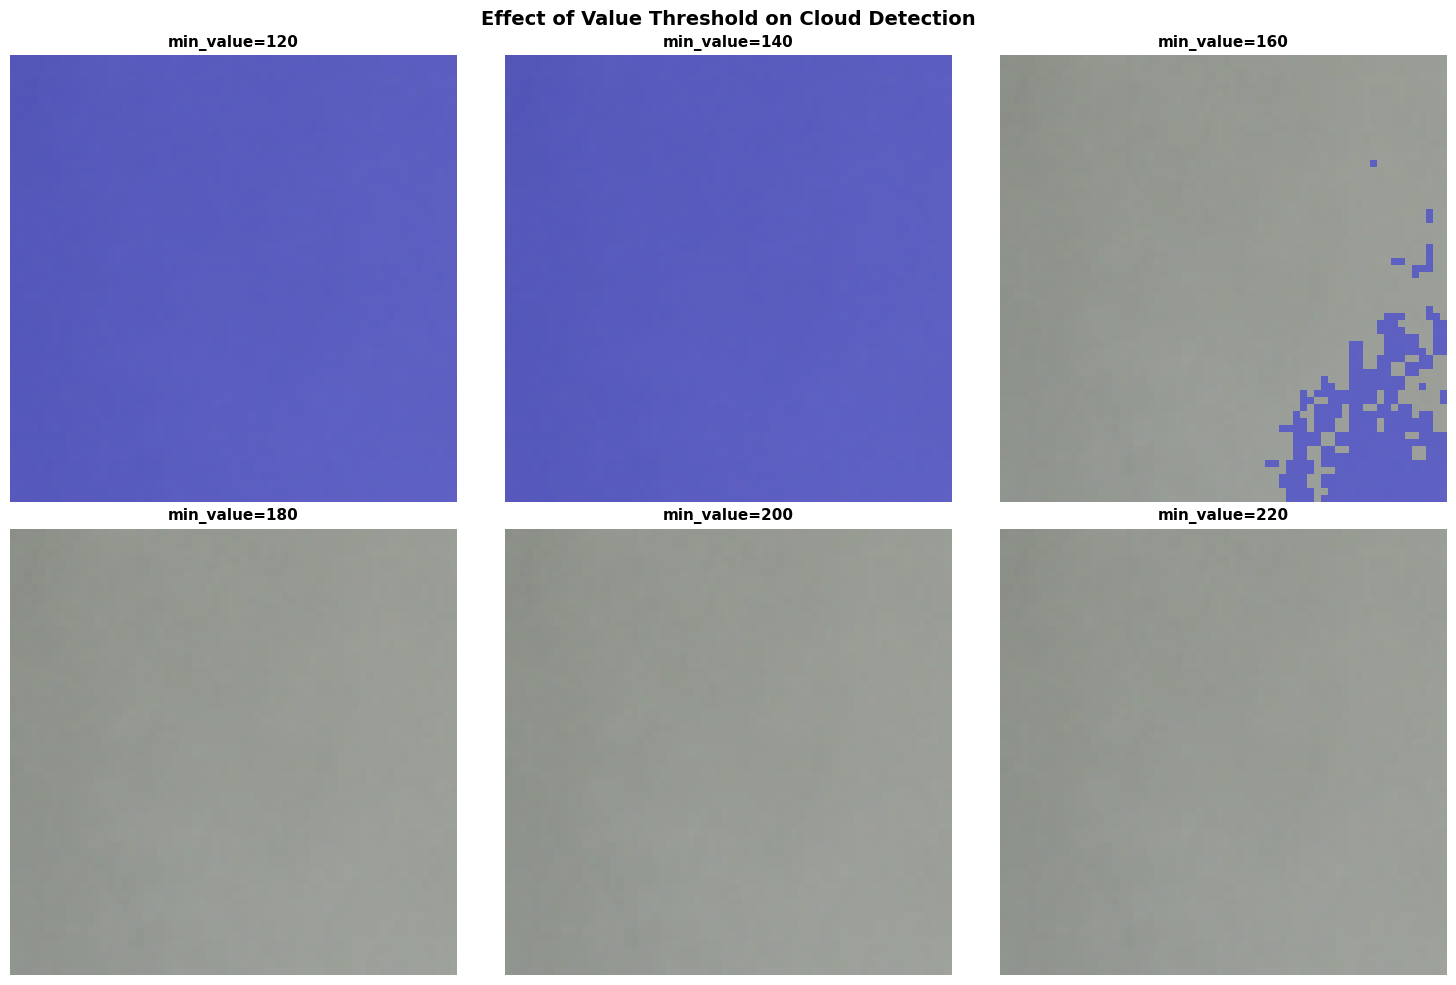

In [13]:
# If results are not satisfactory, experiment with different thresholds
# Load a test image
test_img = cloudy_samples[0]

# Try different Value (brightness) thresholds
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

value_thresholds = [120, 140, 160, 180, 200, 220]

for idx, min_v in enumerate(value_thresholds):
    row = idx // 3
    col = idx % 3
    
    mask = detect_clouds_hsv(test_img, min_value=min_v, max_saturation=80)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'min_value={min_v}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of Value Threshold on Cloud Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

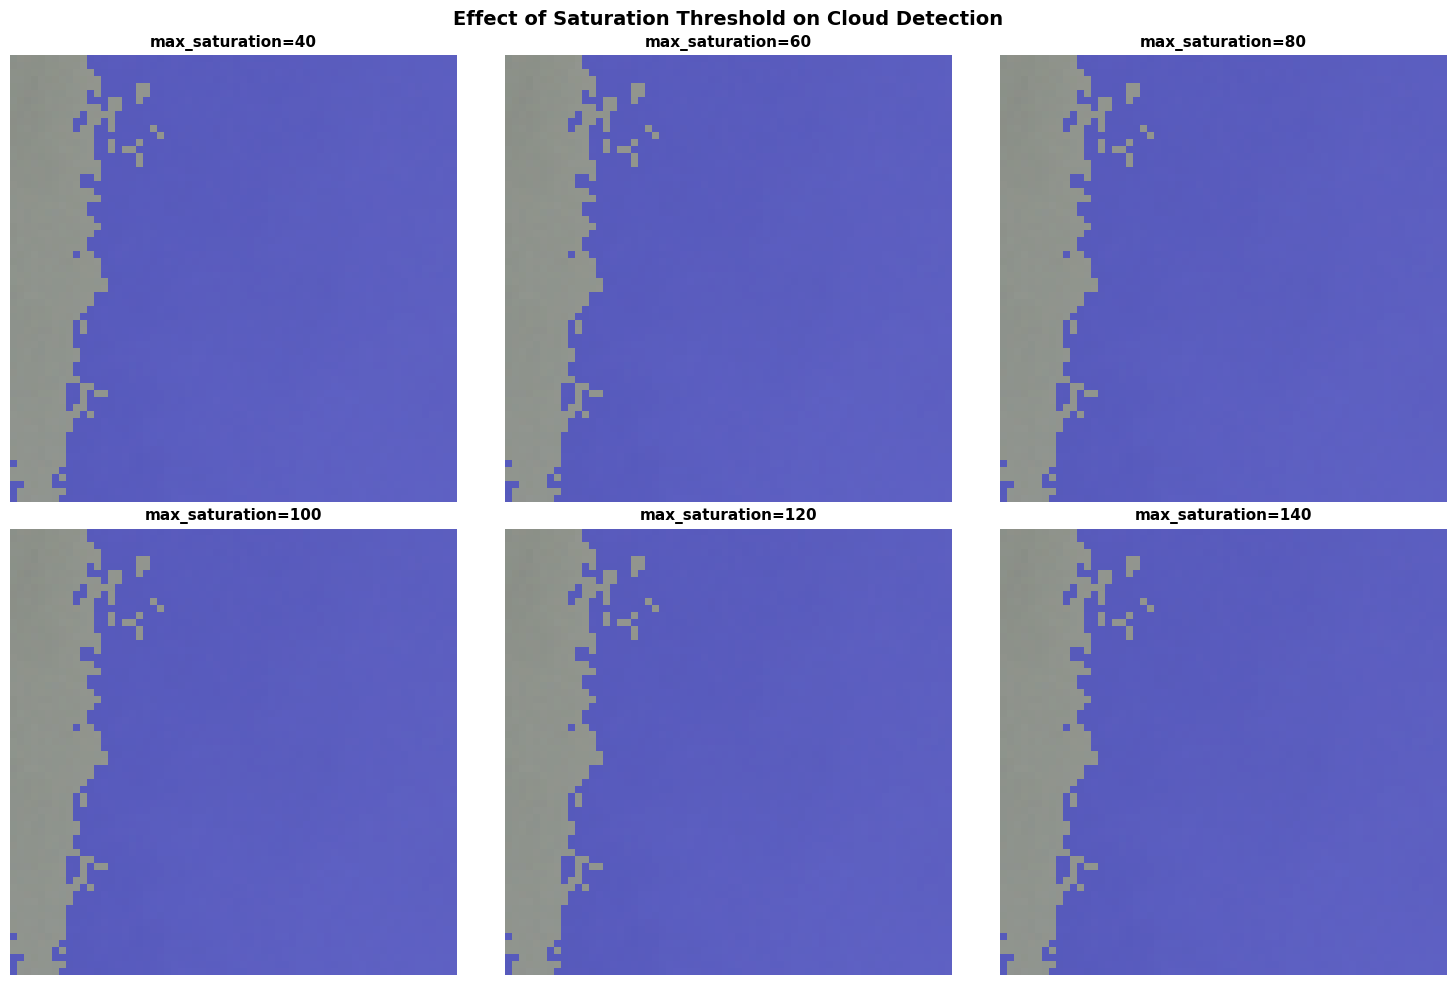

In [14]:
# Try different Saturation thresholds
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

saturation_thresholds = [40, 60, 80, 100, 120, 140]

for idx, max_s in enumerate(saturation_thresholds):
    row = idx // 3
    col = idx % 3
    
    mask = detect_clouds_hsv(test_img, min_value=150, max_saturation=max_s)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'max_saturation={max_s}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of Saturation Threshold on Cloud Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Summary

In [15]:
print("\n" + "="*70)
print("CLOUD DETECTION FILTER - SUMMARY")
print("="*70)

print("\nFilters Implemented:")
print("  1. HSV Filter: High Value (>150) + Low Saturation (<80)")
print("  2. RGB Filter: Low channel std (<25) + High brightness (>150)")
print("  3. Combined: OR operation + morphological cleaning")

print("\nVisualization:")
print("  - Overlay color: Blue (semi-transparent)")
print("  - Side-by-side: Original | Mask | Overlay")

print("\nPerformance on test samples:")
for category in CATEGORIES:
    stats = results[category]
    print(f"  - {category.replace('_', ' ').title()}: {stats['mean']:.1f}% ± {stats['std']:.1f}%")

print("\nKey Insights:")
if results['cloudy']['mean'] > 50:
    print("  ✓ Successfully detects clouds in cloudy images (>50% coverage)")
else:
    print("  ⚠ Low detection in cloudy images - consider tuning thresholds")

non_cloudy_avg = np.mean([results[cat]['mean'] for cat in ['desert', 'green_area', 'water']])
if non_cloudy_avg < 20:
    print("  ✓ Low false positives in non-cloudy images (<20% average)")
else:
    print("  ⚠ High false positives - consider stricter thresholds")

print("\n" + "="*70)
print("✓ Cloud detection filter completed")
print("  Next step: Vegetation detection (02_filter_vegetation.ipynb)")
print("="*70)


CLOUD DETECTION FILTER - SUMMARY

Filters Implemented:
  1. HSV Filter: High Value (>150) + Low Saturation (<80)
  2. RGB Filter: Low channel std (<25) + High brightness (>150)
  3. Combined: OR operation + morphological cleaning

Visualization:
  - Overlay color: Blue (semi-transparent)
  - Side-by-side: Original | Mask | Overlay

Performance on test samples:
  - Cloudy: 57.1% ± 42.2%
  - Desert: 64.0% ± 44.7%
  - Green Area: 0.0% ± 0.0%
  - Water: 0.0% ± 0.0%

Key Insights:
  ✓ Successfully detects clouds in cloudy images (>50% coverage)
  ⚠ High false positives - consider stricter thresholds

✓ Cloud detection filter completed
  Next step: Vegetation detection (02_filter_vegetation.ipynb)
